# Pogona Notebook

In [2]:
from Detector.detector import Detector_v4, Detector_v3
from PIL import Image
import torch
from torchvision import transforms
import Detector.visualize as visualize
import re
import glob
import os
import numpy as np
import imp
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import pickle

In [3]:
detector = Detector_v4(weights_path='Detector/Yolo4/yolo4_gs_best_2306.weights',
                      cfg_path='Detector/Yolo4/yolo4_2306.cfg')

Detector initiated successfully


In [4]:
detector.set_input_size(1440,1080)

## Save prediction video

In [57]:
NUM_FRAMES = 3000
input1 = "../Pogona_Pursuit/Arena/experiments/fast_cockroach_line_20200730T131606/trial2/videos/20200730-132239/19506468.avi"
input2 = "../Pogona_Pursuit/Arena/output/20200615-175044/19506481.avi"
input3 = "../Pogona_Pursuit/Arena/experiments/circle_worm_20200730T125503/trial1/videos/20200730-125503/19506468.avi"

test_video_path = "./Arena/output/20200615-175044/19506481.avi"

times,centroids = visualize.save_pred_video(input1, 
                              "labelled/test20200730fck.mp4", 
                              detector,
                              visAngle=True,
                              dots=True,
                              arrowWindow=240)

  0%|          | 3/5079 [00:00<03:34, 23.70it/s]

saving to:  labelled/test20200730fck.mp4
width: 1440, height: 1080


100%|██████████| 5079/5079 [02:15<00:00, 37.43it/s]


Read: 5.22 ms
Rsz_inf: 12.65 ms
Write: 7.53 ms


Read :  207.0
Rsz_inf :  73.0
Write :  137.0
Average FPS:  39.0


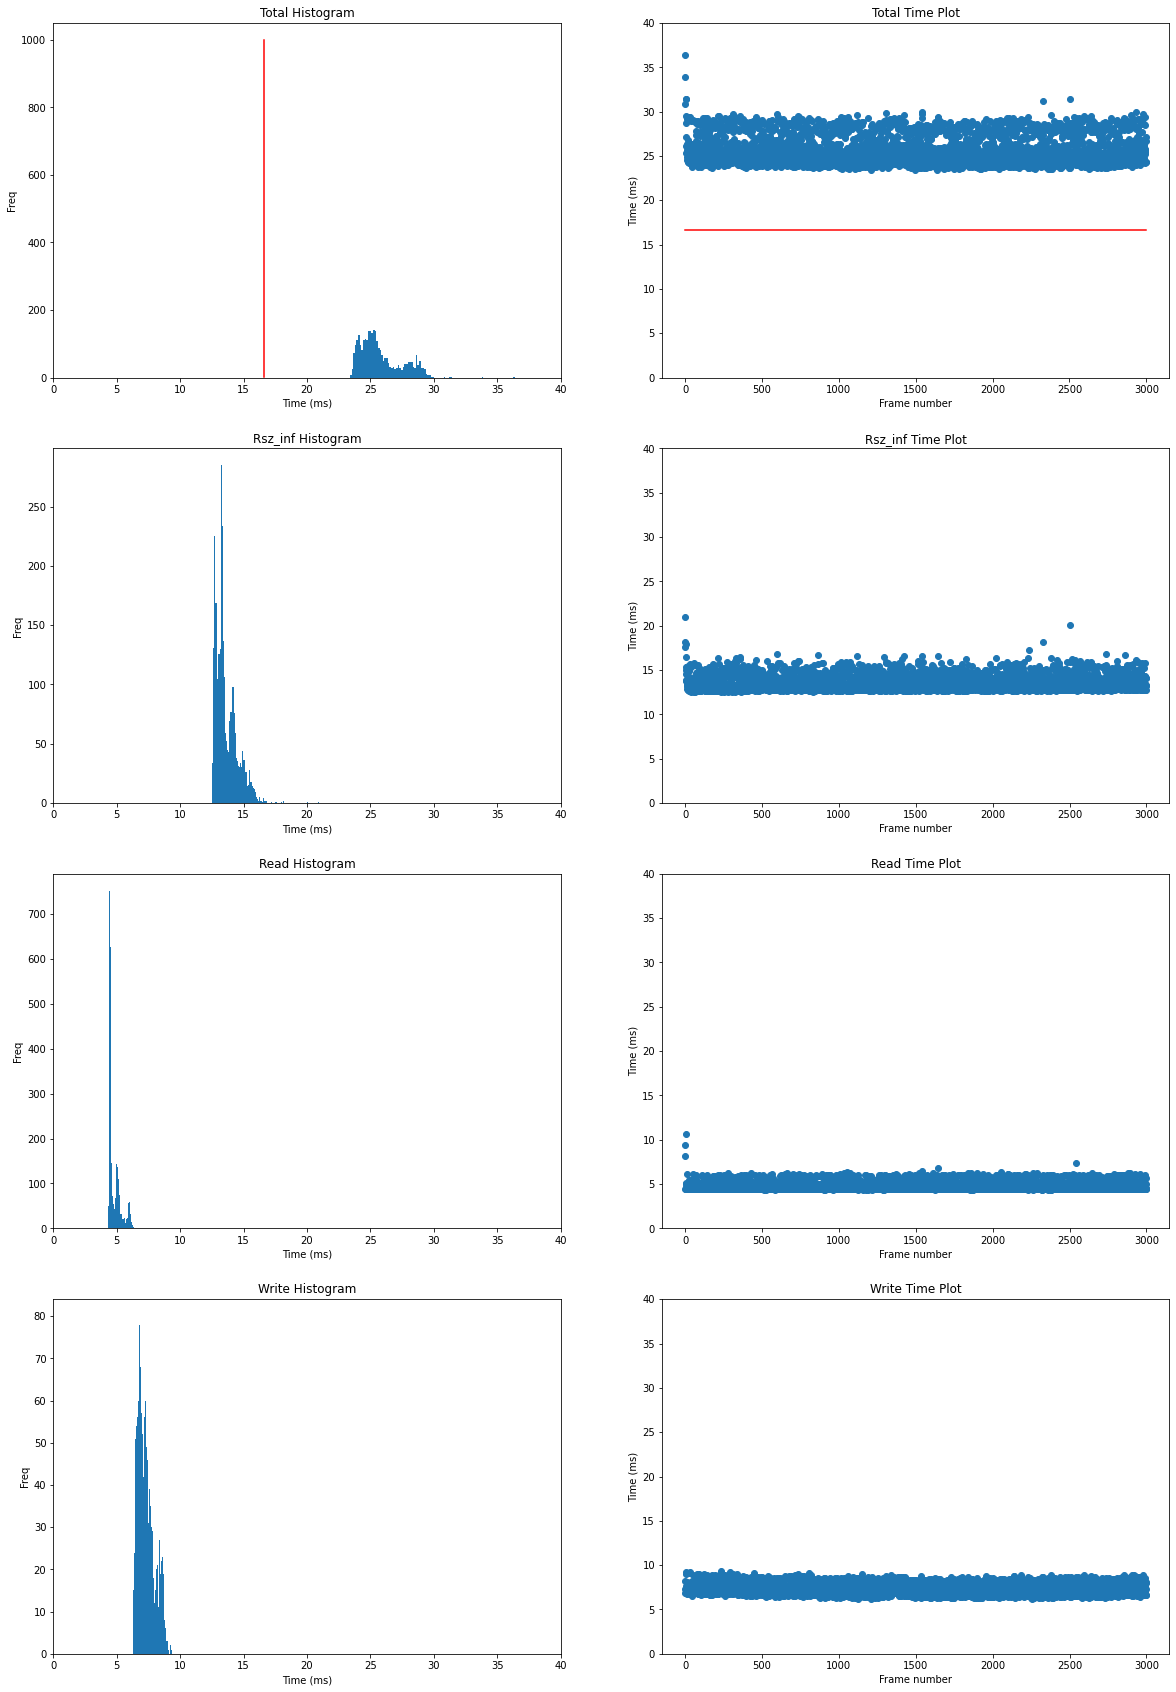

In [15]:
# analyzq timings

XLIM=40
YLIM=40

TOTAL_XLIM = 80
TOTAL_YLIM = 80

centros = centroids[:,:2]
speed = visualize.compute_velocity(centros)

confs = centroids[:,2]
for k in times.keys():
    print(k,": ",round(1/times[k].mean()))
times['Total'] = np.sum(np.stack([times[k] for k in times.keys() if k!='Total'],axis=1),axis=1)
print("Average FPS: ",round(1/times['Total'].mean()))



phases = ['Rsz_inf','Read','Write'] # sorted order
fig,axs = plt.subplots(len(phases)+1,2,figsize=(20,30))
k='Total'
axs[0][0].set_title(k+' Histogram')
axs[0][1].set_title(k+' Time Plot')
axs[0][0].hist(times[k]*1000,label=k,bins=100)
axs[0][0].set_xlim(0,XLIM)
axs[0][0].set_xlabel('Time (ms)')
axs[0][1].set_xlabel('Frame number')
axs[0][0].set_ylabel('Freq')
axs[0][1].set_ylabel('Time (ms)')
axs[0][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
axs[0][1].set_ylim(0,YLIM)
axs[0][0].plot(np.ones(5)*16.6,np.linspace(1,1000,5),color='r')
axs[0][1].plot(np.linspace(1,3000,5),np.ones(5)*16.6,color='r')
for i,k in enumerate(phases):
    i+=1
    axs[i][0].set_title(k+' Histogram')
    axs[i][1].set_title(k+' Time Plot')
    axs[i][0].hist(times[k]*1000,label=k,bins=100)
    axs[i][0].set_xlim(0,XLIM)
    axs[i][0].set_xlabel('Time (ms)')
    axs[i][1].set_xlabel('Frame number')
    axs[i][0].set_ylabel('Freq')
    axs[i][1].set_ylabel('Time (ms)')
    axs[i][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
    axs[i][1].set_ylim(0,YLIM)
#plt.savefig('timings.jpg')

## Plot with figure on video with centroids

In [19]:
%matplotlib agg
#imp.reload(visualize)
#test_video_path = "./Arena/output/20200615-175044/19506481.avi"
visualize.plot_with_figure(input_name=test_video_path,
                           output_name='labelled/1506_181757_2306_figure.mp4',
                           centroids=centroids,
                           num_frames=1000)

  0%|          | 2/1000 [00:00<01:04, 15.57it/s]

width: 1440, height: 1080


100%|██████████| 1000/1000 [01:47<00:00,  9.31it/s]


## Save missed frames

In [3]:
test_video_path = "/media/sil2/regev/pose_estimation/Arena/output/20200521-195335/19506481-0000.avi"
vid_name = '19506481-0000.avi'
path_to = '/media/sil2/regev/pose_estimation/Arena/output/20200521'
L = glob.glob(path_to+'*')
video_paths = []
output_paths = []
for file in L:
    vid_time = re.search('20200521-(\d+)',file).group(1)
    p = os.path.join(path_to+'-'+vid_time,vid_name)
    if os.path.exists(p):
        video_paths.append(p)
        output_paths.append("labelled/arrow_" + vid_time + ".mp4")
        
video_paths

['/media/sil2/regev/pose_estimation/Arena/output/20200521-172245/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172519/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172637/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172842/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173206/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173410/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173606/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174011/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174247/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174430/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-175816/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-180046/

In [30]:
for i in range(len(video_paths)):
    if re.search('20200521-(\d+)',video_paths[i]).group(1)[:2]=='17':
        continue
    inf_time = visualize.save_pred_video(video_paths[i], video_paths[i], detector)
    #print("Inference framerate:", 1/inf_time)

NameError: name 'video_paths' is not defined

In [89]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_Pursuit/Detector/visualize.py'>

In [197]:
input_dir = './Arena/output/20200617-'
time = '222733'
vid_path = input_dir+time+'/19506481.avi'
if os.path.exists(vid_path):;
    visualize.save_missed_frames(video_path=vid_path,
                       output_dir='./new_frames_1806_high/',
                       detector=detector,
                       save_thresh=0.98,
                       num_frames=3000,
                       save_max=250,
                       above=True)

  0%|          | 4/3000 [00:00<01:27, 34.17it/s]

saving to:  ./new_frames_1806_high/


  8%|▊         | 240/3000 [00:04<00:53, 51.39it/s]


KeyboardInterrupt: 

## Abaltion study

In [25]:
im_good = cv.imread('test_images/test_high.jpg')
im_none = cv.imread('test_images/test_none.jpg')
im_low = cv.imread('test_images/test_low4.jpg')

In [27]:
%matplotlib inline

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 45


cells x: 32, cells y: 24, total of 768 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


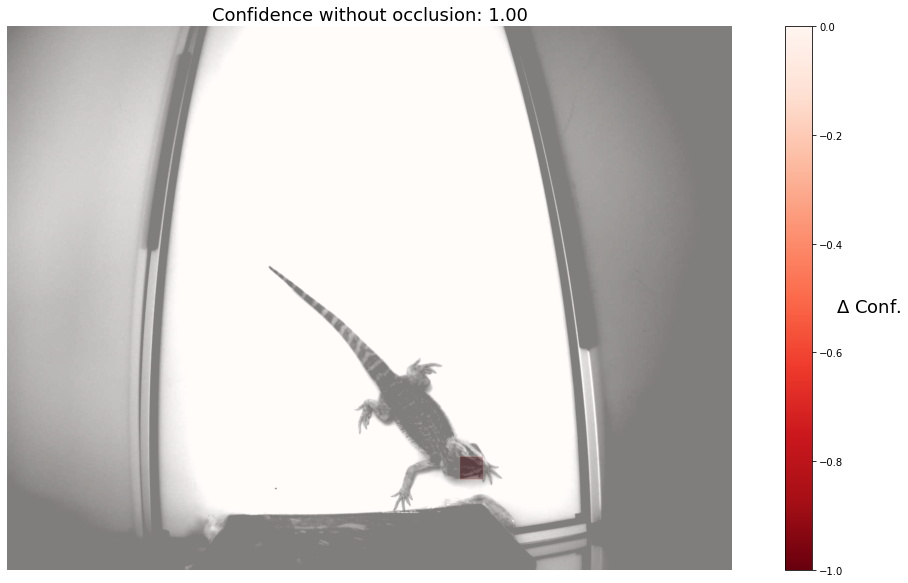

In [39]:
visualize.visualize_ablation_heatmap(im_good,
                                     detector)

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 72


cells x: 20, cells y: 15, total of 300 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


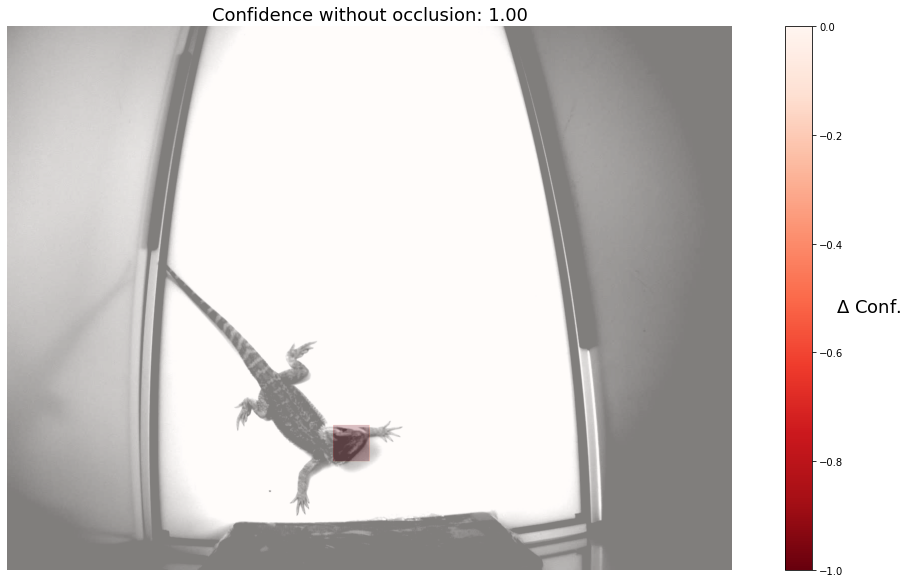

In [43]:
visualize.visualize_ablation_heatmap(im_none,
                                     detector)

Possible cell sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose cell size from the list:


 45


cells x: 32, cells y: 24, total of 768 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


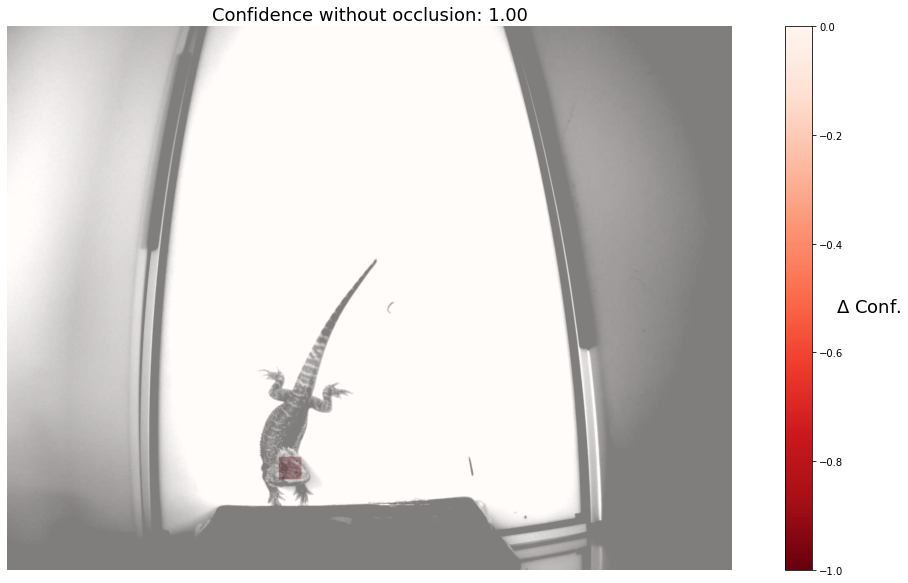

In [36]:
visualize.visualize_ablation_heatmap(im_low,
                                     detector)

For iamges with no or low confidence detection, the ablation may reveal 
what parts of the image cause the detector to fail. 
In the example of test_none.jpg, we can see that if the hand is occluded,
the confidence spikes, so we can deduce that for some reason, this is the part of the inmage
causing the low confidence

In [34]:
im = cv.imread('test_images/test_none_noshadow.jpeg')

In [9]:
detector.set_conf_and_nms(new_conf_thres=0.01)

In [17]:
imgs = os.listdir('/home/user/darknet/data/obj')

# Testing filterpy

In [53]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

In [54]:
my_filter = KalmanFilter(dim_x=4, dim_z=2)
my_filter.x = np.zeros(4) # later init filter with initial location

my_filter.F = np.array([[1.,1.,0.,0.],
                        [0.,1.,0.,0.],
                        [0.,0.,1.,1.],
                        [0.,0.,0.,1.]])    # state transition matrix

my_filter.H = np.array([[1.,0.,0.,0.],
                        [0.,0.,1.,0.]])    # Measurement function
my_filter.P *= 1.                 # covariance matrix
my_filter.R *= 5.      # state uncertainty
q = Q_discrete_white_noise(dim=2, dt=1, var=.1)
my_filter.Q = block_diag(q, q)

In [58]:
filtered_centroids = np.zeros((centroids.shape[0],4))
filtered_centroids[:] = np.nan

for i in range(len(centroids)):
    meas = centroids[i, :2]
    if np.isnan(meas[0]) or np.isnan(meas[1]):
        continue
    #print(meas)
    my_filter.predict()
    my_filter.update(meas)

    # do something with the output
    x = my_filter.x
    filtered_centroids[i] = x

In [62]:
filt_xy = np.stack([filtered_centroids[:,0],filtered_centroids[:,2]],axis=1)

In [63]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_realtime/Detector/visualize.py'>

In [64]:
%matplotlib agg

visualize.plot_with_figure(input_name=input1,
                          output_name="./labelled/kf_test_20200730fastck.avi",
                          centroids = centroids,
                          num_frames=centroids.shape[0],
                          with_figure=False,
                          filtered_centroids=filt_xy)

/app/Pogona_realtime/Detector/visualize.py:553: RuntimeWarning: invalid value encountered in greater
  veloc[veloc > norm_speed] = np.nan
  0%|          | 8/5079 [00:00<01:10, 72.09it/s]

width: 1440, height: 1080


100%|██████████| 5079/5079 [01:15<00:00, 67.03it/s]


In [132]:
filt_deltas = centroids[:,:2] - filt_xy

# Calibration

In [20]:
imgs = [cv.imread('chkr1above.jpg'), cv.imread('chkr2above.jpg')]
imgs = [cv.cvtColor(im,cv.COLOR_BGR2GRAY) for im in imgs]

dims = [(6,9), (9,6)]

# Find the chess board corners
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp1 = np.zeros((6*9,3), np.float32)
objp1[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

objp2 = np.zeros((6*9,3), np.float32)
objp2[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
objpoints.append(objp1)
objpoints.append(objp2)

imgpoints = [] # 2d points in image plane.
chkr_corners = []

for i, im in enumerate(imgs):
    ret, corners = cv.findChessboardCorners(im, dims[i], None)
    corners2 = cv.cornerSubPix(im,corners,dims[i],(-1,-1),criteria)

    chkr_corners.append(cv.drawChessboardCorners(chkr.copy(),tup,corners,ret))
    imgpoints.append(corners)
    
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, imgs[0].shape[::-1],None,None)

In [42]:
# undistort
h,  w = imgs[0].shape[:2]
alpha = 0.5 # determines the amount of distorted pixels in the output image somehow.

newcameramtx, roi=cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),alpha,(w,h))
mapx,mapy = cv.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)

dst = cv.remap(imgs[0],mapx,mapy,cv.INTER_LINEAR)

# crop the image
#x,y,w,h = roi
#dst = dst[y:y+h, x:x+w]
#print(roi)

1080 1440


In [47]:
# get coordinate (50, 100) in the undistorted image.
mapx[50, 100], mapy[50, 100]
mapx.shape

(1080, 1440)

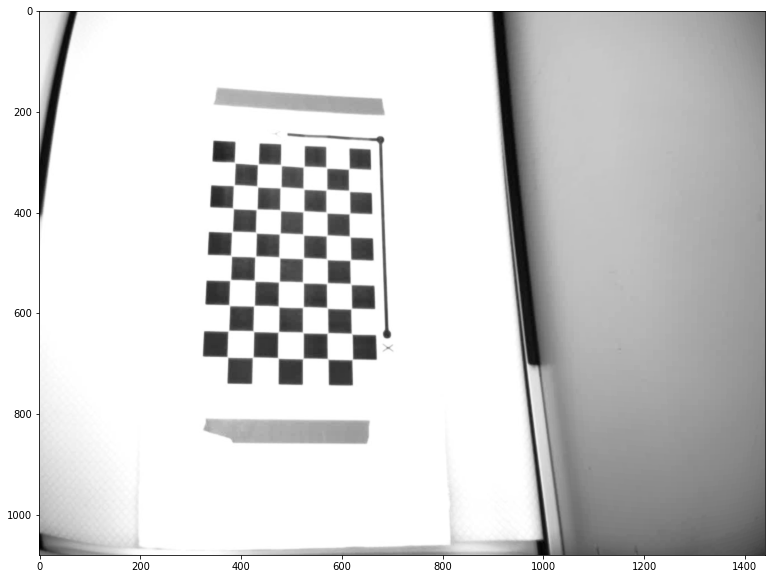

In [43]:
plt.figure(figsize=(13,13))
plt.imshow(dst,cmap='Greys_r')

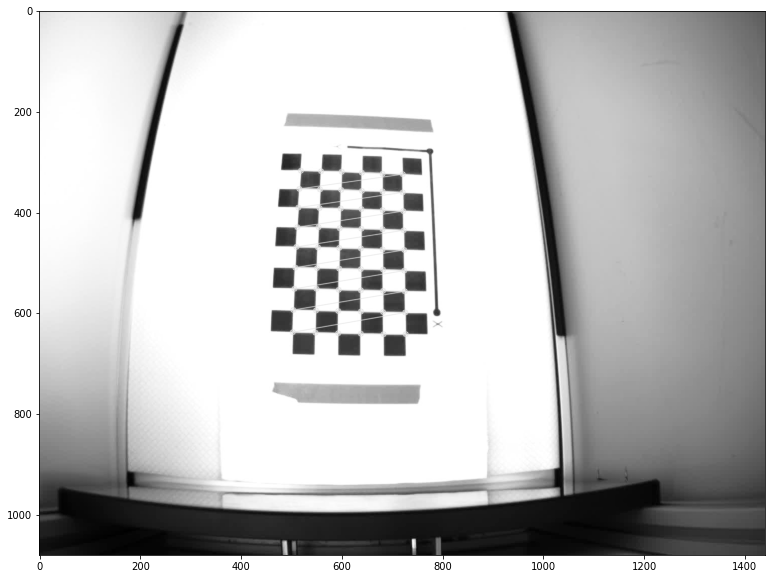

In [50]:
plt.figure(figsize=(13,13))
plt.imshow(chkr_corners[0],cmap='Greys_r')

# Detector and motion analysis

## Notes
Goals:
- analysis of the 2306 weights on large amount of frames (but frames have low variance):
confidence, missed frames, other unwanted behavior.
- analysis of errors made by the animal


Required data structure and stats:
(maybe a class?
experiment:
- num trials
- type
- 
- trials:
    - trial 1:
    - ....
    - trial k:
        screen touches df
        frames df

maybe convert to class based programming if needed)


list of epxeriments, each experiment is a dict with:
    - name of folder
    - timestamp
    - number of trial
    - type: worm\cockroach\etc
name of experiment variable should be the full folder name, to prevent collisions

unified dataframe for all frames data? 
possible to use multi-index with tuple structure:(experiment name, trial #)
what to do with screen touches? maybe there's some way to align screen touch to frame
according to 


- for each experiment, collect:
    * timestamp of experiment: last part of string
    * stimulus: worm, vegtables, cockroach, etc - everything before timestamp 
      not including 'test', 'fps check', 'delete', 'bug_size'
    * Trials dict: dicts indexed by trial number ('trial(k)'), get "screen_touches.csv" ("hits.csv" not needed) and get for each frame:
        - number of bounding boxes before choosing the right one
        - left x, top y, right x, right y, centroid and confidence for the chosen bounding box according to update_centroids function
        (save each experiment-trial(k) frames analysis as a seperate csv in seperate folder?)

install Seaborn without crashing the enviorment

align frames timestamp according to 16506468 exact first frame timestamp - the time in the videos dir name isn't exact
data in output.log. Might take some work, and not be really accurate because the frame rate is only an average.

Better idea: log the timestamps for each frame, and then align with hits in analysis.<br>
The timestamps might not be identical, but they should be very close to each other.<br>
<b>The goal: tagging any "hit" frame.</b>

Another idea:<br>
Make use of the "nose" prediction from the DLC analysis (or even the ears)

In [143]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_realtime/Detector/visualize.py'>

### Experiments detector data collection

In [64]:
all_exper = dict()
base_path = '../Pogona_Pursuit/Arena/experiments/'
exp_dont = ['initial','delete','fps','vegetables']

In [ ]:
"""
TODO: maybe write into functions, cleaner code
TODO: maybe write classes if needed
Note: each trial dataframe is ~100's of KB size
also possible to use a small random sample of trials to accelerate analysis
"""

for exper in glob.glob(base_path+'*'):
    print(f'number of experiments analysed: {len(all_exper.keys())}')
    if not os.path.isdir(exper):
        print(f'{exper} not a dir')
        continue
    if any([dont in exper for dont in exp_dont]):
        print(f'skipped {exper}')
        continue
    
    print(f'analysing {exper}')
    exper_dict = dict()
    
    exper_dict['name'] = os.path.split(exper)[-1]
    trials = glob.glob(exper+'/*')
    exper_dict['num_trials'] = len([k for trial in trials if 'trial' in trial])
    exper_dict['type'] = re.search(base_path+'(.*)_2*',exper).group(1)
    exper_dict['time'] = exper.split('_')[-1]
    print(f'num trials: {exper_dict["num_trials"]}')
    exper_dict['trials'] = dict()
    for k in range(1,exper_dict['num_trials']+1):
        exper_dict['trials'][k] = dict()

        vid_time = os.listdir( os.path.join(exper,f'trial{k}','videos'))[0]
        vid_path = os.path.join(exper,f'trial{k}','videos',vid_time,'19506468.avi')
        if not os.path.exists(vid_path):
            exper_dict['trials'][k]['no_realtime'] = True
            continue
        exper_dict['trials'][k]['no_realtime'] = False
        exper_dict['trials'][k]['vid_time'] = vid_time
        frames_data_test = visualize.stats_save_frames_data(video_path=vid_path,detector=detector)
        exper_dict['trials'][k]['frames'] = pd.DataFrame(data=frames_data_test,
                                                         columns=('centroid_x','centroid_y','left_x','top_y',
                                                                  'right_x','bottom_y','conf','num_bbox'))
        screen_path = os.path.join(exper,f'trial{k}','screen_touches.csv')
        if not os.path.exists(screen_path):
            exper_dict['trials'][k]['no_screen'] = True
            continue
        exper_dict['trials'][k]['no_screen'] = False
        exper_dict['trials'][k]['screen'] = pd.read_csv(screen_path,
                                                        usecols = ['x','y','bug_x','bug_y','timestamp'], parse_dates = ['timestamp'])
        #maybe add exper a trial constant columns for unified dataframe
        #exper_dict['trials'][k]['frames']['exper'] = exper_dict['name']
        #exper_dict['trials'][k]['frames']['trial'] = k
        """
        TODO DLC: maybe parse the DLC putput for camera 68, or spcifically the nose data
        TODO timestamps: change format if we add frames timestamp, so the frames dataframe will be include
        a timestamp column. relevant only for future experiments
        """
 
    all_exper[exper_dict['name']] = exper_dict
    #break
        

  0%|          | 5/4539 [00:00<01:35, 47.24it/s]

number of experiments analysed: 0
skipped ../Pogona_Pursuit/Arena/experiments/initial_20200727T071226
number of experiments analysed: 0
skipped ../Pogona_Pursuit/Arena/experiments/initial_20200727T073708
number of experiments analysed: 0
analysing ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358
num trials: 4
analysing ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/19506468.avi, num_frames 4539


  0%|          | 6/4819 [00:00<01:26, 55.60it/s]

analysing ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial2/videos/20200727-081031/19506468.avi, num_frames 4819


  0%|          | 6/4778 [00:00<01:34, 50.54it/s]

analysing ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial3/videos/20200727-081705/19506468.avi, num_frames 4778


  0%|          | 6/4583 [00:00<01:28, 51.58it/s]

analysing ../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial4/videos/20200727-082337/19506468.avi, num_frames 4583


  0%|          | 6/5309 [00:00<01:43, 51.07it/s]

number of experiments analysed: 1
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T083454
number of experiments analysed: 1
analysing ../Pogona_Pursuit/Arena/experiments/test_20200727T100404
num trials: 1
analysing ../Pogona_Pursuit/Arena/experiments/test_20200727T100404/trial1/videos/20200727-100404/19506468.avi, num_frames 5309


  0%|          | 5/5080 [00:00<01:50, 45.82it/s]

number of experiments analysed: 2
skipped ../Pogona_Pursuit/Arena/experiments/test_fps_20200727T102701
number of experiments analysed: 2
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T105124
number of experiments analysed: 2
skipped ../Pogona_Pursuit/Arena/experiments/fps_check_20200727T110833
number of experiments analysed: 2
skipped ../Pogona_Pursuit/Arena/experiments/delete_20200727T161744
number of experiments analysed: 2
skipped ../Pogona_Pursuit/Arena/experiments/initial_20200729T071920
number of experiments analysed: 2
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T074653
num trials: 1
number of experiments analysed: 3
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T075548
num trials: 3
number of experiments analysed: 4
analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial1/videos/20200729-084032/19506468.avi, num_frames 5080


  0%|          | 6/5080 [00:00<01:40, 50.48it/s]

analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T084031/trial2/videos/20200729-084703/19506468.avi, num_frames 5080


  0%|          | 6/5081 [00:00<01:41, 50.05it/s]

number of experiments analysed: 5
skipped ../Pogona_Pursuit/Arena/experiments/vegetables_20200729T084925
number of experiments analysed: 5
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T090421
num trials: 3
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial1/videos/20200729-090421/19506468.avi, num_frames 5081


  0%|          | 6/5081 [00:00<01:40, 50.73it/s]

analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial2/videos/20200729-091053/19506468.avi, num_frames 5081


  0%|          | 5/5081 [00:00<01:49, 46.22it/s]

analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T090421/trial3/videos/20200729-091725/19506468.avi, num_frames 5081


  0%|          | 6/5081 [00:00<01:38, 51.28it/s]

number of experiments analysed: 6
skipped ../Pogona_Pursuit/Arena/experiments/vegetables_20200729T092014
number of experiments analysed: 6
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T094929
num trials: 3
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T094929/trial1/videos/20200729-094929/19506468.avi, num_frames 5081


  0%|          | 5/5081 [00:00<01:57, 43.36it/s]

analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T094929/trial2/videos/20200729-095422/19506468.avi, num_frames 5081


  0%|          | 6/4825 [00:00<01:37, 49.30it/s]

number of experiments analysed: 7
analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T101509
num trials: 3
analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T101509/trial1/videos/20200729-101510/19506468.avi, num_frames 4825


  0%|          | 6/4805 [00:00<01:37, 49.40it/s]

analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T101509/trial2/videos/20200729-102142/19506468.avi, num_frames 4805


  0%|          | 6/4604 [00:00<01:30, 50.93it/s]

analysing ../Pogona_Pursuit/Arena/experiments/cockroach_20200729T101509/trial3/videos/20200729-102816/19506468.avi, num_frames 4604


  0%|          | 6/4586 [00:00<01:32, 49.77it/s]

number of experiments analysed: 8
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T103122
num trials: 3
analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial1/videos/20200729-103123/19506468.avi, num_frames 4586


  0%|          | 6/4731 [00:00<01:37, 48.43it/s]

analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial2/videos/20200729-103756/19506468.avi, num_frames 4731


  0%|          | 6/4746 [00:00<01:34, 50.14it/s]

analysing ../Pogona_Pursuit/Arena/experiments/worm_20200729T103122/trial3/videos/20200729-104429/19506468.avi, num_frames 4746


  0%|          | 6/5080 [00:00<01:42, 49.34it/s]

number of experiments analysed: 9
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342
num trials: 3
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342/trial1/videos/20200729-105345/19506468.avi, num_frames 5080


  0%|          | 5/5081 [00:00<01:49, 46.41it/s]

analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342/trial2/videos/20200729-110019/19506468.avi, num_frames 5081


  0%|          | 6/5080 [00:00<01:45, 47.98it/s]

analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T105342/trial3/videos/20200729-110652/19506468.avi, num_frames 5080


  0%|          | 6/5080 [00:00<01:41, 50.08it/s]

number of experiments analysed: 10
skipped ../Pogona_Pursuit/Arena/experiments/vegetables_20200729T111144
number of experiments analysed: 10
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T093829
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T093829/trial1/videos/20200729-093829/19506468.avi, num_frames 5080


  0%|          | 6/5081 [00:00<01:51, 45.63it/s]

analysing ../Pogona_Pursuit/Arena/experiments/fast_cockroach_20200729T093829/trial2/videos/20200729-094500/19506468.avi, num_frames 5081


  0%|          | 6/5080 [00:00<01:42, 49.41it/s]

number of experiments analysed: 11
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T115819
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T115819/trial1/videos/20200730-115820/19506468.avi, num_frames 5080


  0%|          | 5/5080 [00:00<01:43, 49.23it/s]

analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T115819/trial2/videos/20200730-120452/19506468.avi, num_frames 5080


  1%|          | 5/846 [00:00<00:17, 49.01it/s]

number of experiments analysed: 12
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T120805
num trials: 1
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T120805/trial1/videos/20200730-120806/19506468.avi, num_frames 846


  0%|          | 6/5081 [00:00<01:39, 50.97it/s]

number of experiments analysed: 13
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T120821
num trials: 1
number of experiments analysed: 14
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T113527
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T113527/trial1/videos/20200730-113528/19506468.avi, num_frames 5081


  0%|          | 6/5080 [00:00<01:45, 47.89it/s]

analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T113527/trial2/videos/20200730-114200/19506468.avi, num_frames 5080


  0%|          | 5/4988 [00:00<01:44, 47.70it/s]

number of experiments analysed: 15
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T124208
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T124208/trial1/videos/20200730-124209/19506468.avi, num_frames 4988


  0%|          | 5/5064 [00:00<02:05, 40.38it/s]

analysing ../Pogona_Pursuit/Arena/experiments/circle_20200730T124208/trial2/videos/20200730-124841/19506468.avi, num_frames 5064


  0%|          | 5/4952 [00:00<01:41, 48.91it/s]

number of experiments analysed: 16
analysing ../Pogona_Pursuit/Arena/experiments/circle_worm_20200730T125503
num trials: 2
analysing ../Pogona_Pursuit/Arena/experiments/circle_worm_20200730T125503/trial1/videos/20200730-125503/19506468.avi, num_frames 4952


  0%|          | 5/4908 [00:00<01:47, 45.56it/s]

analysing ../Pogona_Pursuit/Arena/experiments/circle_worm_20200730T125503/trial2/videos/20200730-130135/19506468.avi, num_frames 4908


 18%|█▊        | 863/4908 [00:15<01:13, 54.75it/s]

In [180]:
all_exper['bug_size_20200727T080358']['trials'][1]['screen']

,x,y,bug_x,bug_y,timestamp
0,1677,301,1642,335,2020-07-27 08:04:00.713120
1,88,368,88,333,2020-07-27 08:04:23.311063
2,73,224,46,227,2020-07-27 08:04:28.749953
3,163,743,145,778,2020-07-27 08:05:00.526074


In [179]:
all_exper['bug_size_20200727T080358']['trials'][1]['frames']

,centroid_x,centroid_y,left_x,top_y,right_x,bottom_y,conf,num_bbox
0,813.320869,262.907513,772.320869,220.907513,854.431450,306.772175,0.994439,1.0
1,813.145901,263.271194,772.145901,221.271194,854.890110,305.969467,0.994998,1.0
2,813.000114,262.923824,772.000114,220.923824,854.908699,306.517338,0.994870,1.0
3,811.838043,263.460354,771.838043,221.460354,853.178802,305.525120,0.994992,1.0
4,806.556713,266.650841,765.556713,225.650841,848.075733,309.638771,0.996045,1.0
...,...,...,...,...,...,...,...,...
4534,853.822540,841.714176,799.822540,791.714176,909.473114,891.902279,0.996798,1.0
4535,854.418385,840.965023,799.418385,791.965023,909.561474,891.826359,0.996882,1.0
4536,853.658470,841.566406,799.658470,792.566406,909.319435,891.843872,0.996674,1.0
4537,853.554596,841.800266,799.554596,791.800266,909.251190,891.861843,0.996899,1.0


In [117]:
first=True
for exper in all_exper.keys():
    for trial in all_exper[exper]['trials'].keys():
        if first:
            if all_exper[exper]['trials'][trial]['no_realtime']:
                continue
            all_df = all_exper[exper]['trials'][trial]['frames']
            first=False
        else:
            if all_exper[exper]['trials'][trial]['no_realtime']:
                continue
            all_df = pd.concat([all_df,all_exper[exper]['trials'][trial]['frames']])

Text(0.5, 1.0, 'Confidence distribution for 174685 frames')

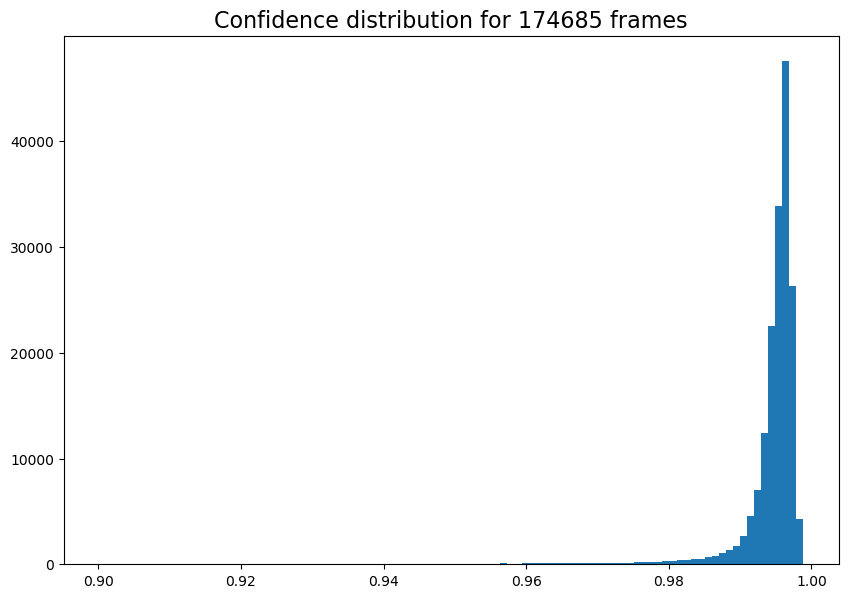

In [118]:
plt.figure(figsize=(10,7),dpi=100)
h=plt.hist(all_df.conf,bins=100)
plt.title(f'Confidence distribution for {all_df.shape[0]} frames',fontsize=16)

In [119]:
print(f'{(all_df.num_bbox == 1).sum()/(all_df.shape[0])*100:.3f} % with a single bbox')

99.428 % with a single bbox


In [124]:
first=True
for exper in all_exper.keys():
    for trial in all_exper[exper]['trials'].keys():
        if first:
            if all_exper[exper]['trials'][trial]['no_realtime']:
                continue
            if all_exper[exper]['trials'][trial]['no_screen']:
                continue
            all_screen = all_exper[exper]['trials'][trial]['screen']
            first=False
        else:
            if all_exper[exper]['trials'][trial]['no_realtime']:
                continue
            if all_exper[exper]['trials'][trial]['no_screen']:
                continue
            all_screen = pd.concat([all_screen,all_exper[exper]['trials'][trial]['screen']])

In [189]:
max(all_screen.x)

2242

In [157]:
for row in all_screen.iterrows():
    print(type(row[1][:2].values))
    break

<class 'numpy.ndarray'>


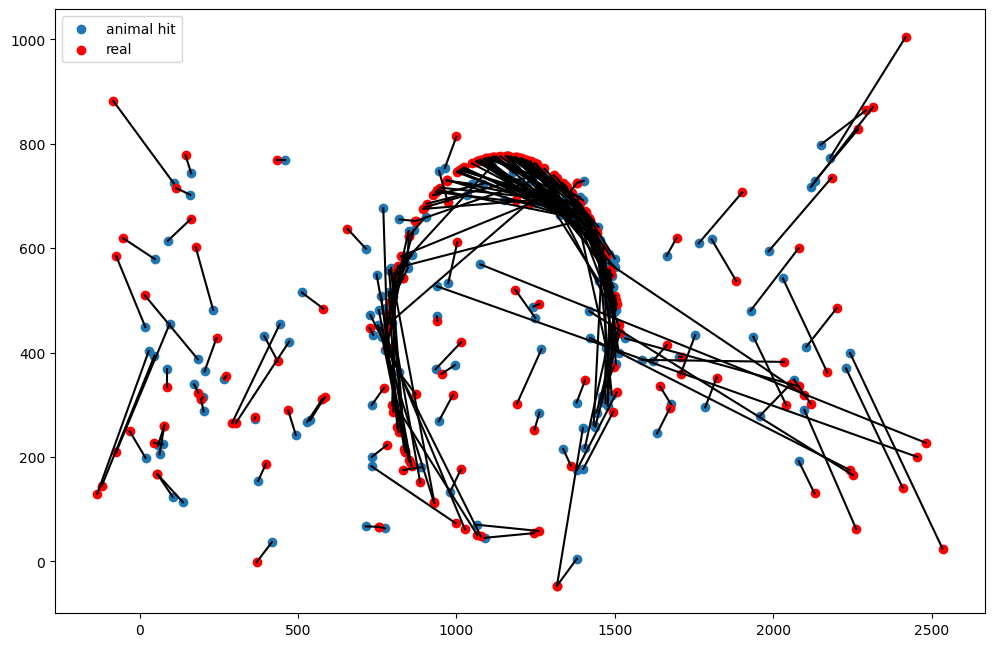

In [165]:
plt.figure(figsize=(12,8),dpi=100)
plt.scatter(all_screen.x,all_screen.y,label='animal hit')
plt.scatter(all_screen.bug_x,all_screen.bug_y,label='real',color='r')
for row in all_screen.iterrows():
    p1 = row[1][:2].values
    p2 = row[1][2:4].values
    ps = np.stack([p1,p2])
    plt.plot(ps[:,0],ps[:,1],color='k')
plt.legend()
plt.title('')

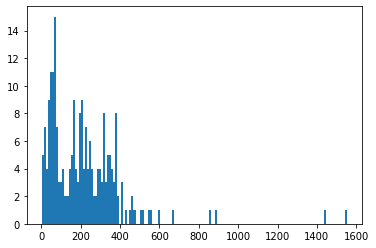

In [175]:
dists = np.linalg.norm((all_screen.values[:,:2]-all_screen.values[:,2:4]).astype('float'),axis=1)
h=plt.hist(dists,bins=150)

### Parsing DLC file example

In [181]:
dlc_file = '../Pogona_Pursuit/Arena/experiments/bug_size_20200727T080358/trial1/videos/20200727-080358/19506468DLC_resnet50_pogona_pursuitJul19shuffle1_400000.csv'
dlc = pd.read_csv(dlc_file)
ar = dlc.iloc[:2].values
mult = list(zip(ar[0],ar[1]))[1:]
dlc.drop(index=[0,1],inplace=True)
dlc.reset_index(inplace=True)
dlc.drop(columns=['scorer','index'],inplace=True)
dlc.columns = pd.MultiIndex.from_tuples(mult)
dlc = dlc.astype('float64')

In [197]:
dlc2=pd.read_csv(dlc_file)

In [194]:
dlc.head()

nose                           left_ear                         \
            x           y likelihood           x           y likelihood   
0  777.675537  236.964233   0.999443  835.027710  291.999847   0.999993   
1  778.192261  236.598480   0.999699  835.764526  291.560852   0.999977   
2  777.793030  236.619385   0.999438  835.481750  291.704681   0.999981   
3  777.756226  237.098602   0.999537  835.650513  291.306702   0.999953   
4  776.839355  239.953369   0.999793  834.345520  292.351044   0.999828   

    right_ear                          forelegL1  ...  hindlegR1   hindlegR2  \
            x           y likelihood           x  ... likelihood           x   
0  494.694244  924.933533   0.954301  753.394714  ...   0.996840  861.998169   
1  498.879517  923.708008   0.935991  752.390076  ...   0.995993  862.229980   
2  848.514832  262.268372   0.925258  752.978394  ...   0.994918  862.053406   
3  494.096069  924.750183   0.896125  753.832031  ...   0.997671  863.262939   
4  808.237305  308.855377   0.954414  753.935913  ...   0.979696  863.972595   

                               tail1                              tail2  \
            y likelihood           x           y likelihood           x   
0  453.821075   0.999989  820.601074  469.165649   0.999968  673.972412   
1  452.949463   0.999996  820.848572  470.336578   0.999949  672.842102   
2  453.555328   0.999994  821.394348  468.940826   0.999981  666.909241   
3  452.765686   0.999992  822.107788  470.161713   0.999960  672.436401   
4  452.968964   0.999998  823.951294  468.966644   0.999769  672.657471   

                          
            y likelihood  
0  645.071655   0.985971  
1  644.986267   0.997004  
2  644.747681   0.997806  
3  644.942383   0.993959  
4  645.333740   0.994639  

[5 rows x 39 columns]

### Pickle code snippet example

In [94]:
with open('stats/all_experiments_dict_0108.p','wb') as fp:
    pickle.dump(all_exper,fp)

In [95]:
with open('stats/all_experiments_dict_0108.p','rb') as fp:
    loaded_dict = pickle.load(fp)